In [1]:
import os, glob
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import seaborn as sns
import matplotlib.pyplot as plt

Nez prijde mraz A Okna zaskli, nez prijde zima led a snih,
spravim si boty, uz mi prasly a couhaji mi palce z nich.

In [2]:
import glob, os

#"training_data/*.txt"

def read_training(gl):
    tr = {}
    for file in glob.glob(gl):
        n = int(file.split("/")[1].split(".")[0])
        with open(file) as f:
            fc = f.read()
        ss = fc.split("\n\n")
        ls = []
        ns = 0
        for s in ss:
                      
            tts = s.split("\n")
            xs, ys = [],[]
            for t in tts:
                if not t.strip():
                    continue
                x,y = t.strip().split(" ")
                xs.append(float(x))
                ys.append(float(y))
            ls.append((np.array(xs),np.array(ys)))
        tr[n] = ls           
    return tr

ts = read_training("training_data/*.txt")

In [3]:
ff = [0.2942669,0.8612692, 0.2940692,0.5935954]

In [4]:
file = "ground_truth.txt"
with open(file) as f:
    fc = f.read()
ss = fc.split("\n\n")
truth = []
ns = 0
for s in ss:

    tts = s.split("\n")
    xs, ys = [],[]
    for t in tts:
        if not t.strip():
            continue
        x,y = t.strip().split(" ")
        xs.append(float(x))
        ys.append(float(y))
    truth.append((np.array(xs),np.array(ys)))

In [5]:
line = [(0,0),(1,0),(2,0),(2,1),(2,2),(1,2),(0,2),(0,1),(0,0)]
print(rdp(line,1))

NameError: name 'rdp' is not defined

In [129]:
import os
import sys
from math import sqrt
import numpy as np
import io


def read_training(d):
    tr = {}
    for file in os.listdir(d):
        n = int(file.split(".")[0])
        with open(os.path.join(d,file)) as f:
            fc = f.read()
        ss = fc.split("\n\n")
        ls = []
        ns = 0
        for s in ss:
                      
            tts = s.split("\n")
            xs, ys = [],[]
            for t in tts:
                if not t.strip():
                    continue
                x,y = t.strip().split(" ")
                xs.append(float(x))
                ys.append(float(y))
            ls.append((np.array(xs),np.array(ys)))
        tr[n] = ls           
    return tr


def distance(a, b):
    return  sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def point_line_distance(point, start, end):
    if (start == end):
        return distance(point, start)
    else:
        n = abs(
            (end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1])
        )
        d = sqrt(
            (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2
        )
        return n / d

def rdp(points, epsilon):
    """
    Reduces a series of points to a simplified version that loses detail, but
    maintains the general shape of the series.
    """
    dmax = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    if dmax >= epsilon:
        results = rdp(points[:index+1], epsilon)[:-1] + rdp(points[index:], epsilon)
    else:
        results = [points[0], points[-1]]
    return results


def median(lst):
    sortedLst = sorted(lst)
    lstLen = len(lst)
    index = (lstLen - 1) // 2    
    return sortedLst[index] 


class Traj:
    def __init__(self,xsys):
        xs, ys = xsys
        a = np.array(xsys).T
        _, filtered = np.unique(a, return_index=True,axis=0)
        if len(filtered) < 2:
            raise OnlyOnePointError()
        self.xs = np.array(xs)[sorted(filtered)]
        self.ys = np.array(ys)[sorted(filtered)]
        self.xd = np.diff(xs)
        self.yd = np.diff(ys)
        self.dists = np.linalg.norm([self.xd, self.yd],axis=0)
        self.cuts = np.cumsum(self.dists)
        self.d = np.hstack([0,self.cuts])
        
    def getPoints(self, offsets):        
        offdists = offsets * self.cuts[-1]
        ix = np.searchsorted(self.cuts, offdists)        
        offdists -= self.d[ix]
        segoffs = offdists/self.dists[ix]
        x = self.xs[ix] + self.xd[ix]*segoffs
        y = self.ys[ix] + self.yd[ix]*segoffs
        return x,y        


class SampleSet:
    def __init__(self, n, ll):
        # ll is list of tuples [x_array,y_array] for every trajectory in sample
        self.trajs = [Traj(l) for l in ll]
        self.n = n
        self.xp = None
        self.yp = None
        self.err= None
        self.d = None
        self.filtix = None
        self.lenoutix = None
        self.disoutix = None
        self.eps = None

    def getRawAvg(self):
        trajLen = median([len(t.xs) for t in self.trajs])
        offs = np.linspace(0,1,trajLen)
        xm = []
        ym = []
        for t in self.trajs:
            xs, ys = t.getPoints(offs)
            xm.append(xs)
            ym.append(ys)        
        xp, yp = np.mean(xm, axis=0), np.mean(ym, axis=0)
        return xp, yp

    def getFiltered(self, dismax, lenlim):
        xa, ya = self.getRawAvg()
        d = zscore(np.array([disterr(t.xs, t.ys, xa, ya) for t in self.trajs]))
        l = self.zlen()
        self.lenoutix = np.where((l<lenlim[0])|(l>lenlim[1]))[0]
        
        lenix = np.where((l>lenlim[0])&(l<lenlim[1]))[0]
        self.disoutix = np.where(d>dismax)[0]
        
        disix = np.where(d<dismax)[0]
        self.d = d
        self.l = l
        self.filtix = np.intersect1d(lenix,disix)

    def getAvg(self, dismax, lenlim, eps):
        self.eps = eps
        self.endpoints()        
        self.getFiltered(dismax, lenlim)
        
        atleast = 4
        if len(self.filtix) <= atleast:            
            distrank = np.argsort(self.d)
            self.disoutix = distrank[atleast:]
            self.lenoutix = []
            self.filtix = distrank[:atleast]
        filtered = [self.trajs[i] for i in self.filtix]
        trajLen = median([len(t.xs) for t in filtered])
        offs = np.linspace(0,1,trajLen*10)
        xm = []
        ym = []
        for t in filtered:
            xs, ys = t.getPoints(offs)            
            xm.append(xs)
            ym.append(ys)
        self.xp, self.yp = zip(*rdp(list(zip(np.mean(xm, axis=0),np.mean(ym, axis=0))), eps))
        #self.xp, self.yp = np.mean(xm, axis=0), np.mean(ym, axis=0)
        tx = truth[self.n][0]
        ty = truth[self.n][1]
        self.err = disterr(self.xp, self.yp, tx,ty)
    
    def endpoints(self):
        cs = np.array([[self.trajs[0].xs[0],self.trajs[0].xs[-1]],
                       [self.trajs[0].ys[0],self.trajs[0].ys[-1]]])
        xs = np.hstack([t.xs[0] for t in self.trajs] + [t.xs[-1] for t in self.trajs])
        ys = np.hstack([t.ys[0] for t in self.trajs] + [t.ys[-1] for t in self.trajs])       
        clabs = []
        oldclabs = []
        for j in range(10):
            for i in range(len(xs)):
                ap = np.array([[xs[i]],[ys[i]]])
                dists = np.linalg.norm(ap - cs, axis=0)
                clabs.append(np.argmin(dists))
            cx = np.array([
                np.mean(xs[np.where(np.array(clabs)==0)]),
                np.mean(xs[np.where(np.array(clabs)==1)])])
            cy = np.array([
                np.mean(ys[np.where(np.array(clabs)==0)]),
                np.mean(ys[np.where(np.array(clabs)==1)])])
            if oldclabs == clabs:
                break
            oldclabs = clabs
            clabs = []
        
        for i,l in enumerate(clabs[:len(clabs)//2]):
            if l == 1:
                oldT = self.trajs[i]                
                reversedTraj = (np.flip(oldT.xs, axis=0), np.flip(oldT.ys, axis=0))
                self.trajs[i] = Traj(reversedTraj)                
    
    def zlen(self):
        ls = np.array([t.cuts[-1] for t in self.trajs])
        return zscore(ls)
        
    def pax(self, ax):
        
        ax.set_xlim(0,1)
        ax.set_xticks([])
        ax.set_yticks([])        
        ax.set_ylim(0,1)
                
        for _, t in enumerate(self.trajs):    
            ax.plot(t.xs,t.ys, c="b", marker="o", markersize=2)
        for n, t in enumerate([self.trajs[i] for i in self.disoutix]):    
            ax.plot(t.xs,t.ys, c="g")
        for n, t in enumerate([self.trajs[i] for i in self.lenoutix]):    
            ax.plot(t.xs,t.ys, c="cyan")
        for n, t in enumerate([self.trajs[i] for i in np.intersect1d(self.lenoutix,self.disoutix)]):    
            ax.plot(t.xs,t.ys, c="magenta")
        if self.xp is not None:
            ax.plot(self.xp,self.yp, marker='D', color='r', linewidth=3)            
        tx = truth[self.n][0]
        ty = truth[self.n][1]
        ax.plot(tx,ty, marker="o",color="black",linewidth=3)
            
        
        if self.xp is not None:
            ax.set_xlabel("#%d err:%.3f eps:%.3f,t: %d, f: %d out: %d" % 
                          (self.n, self.err, self.eps, len(self.trajs), len(self.filtix),
                           len(self.disoutix)+len(self.lenoutix)))

def disterr(x1,y1, x2, y2):        
    sd = np.array([x1[0]-x2[0],y1[0]-y2[0]])
    ed = np.array([x1[0]-x2[-1],y1[0]-y2[-1]])
    if np.linalg.norm(sd) > np.linalg.norm(ed):
        x2 = np.flip(x2, axis=0)
        y2 = np.flip(y2, axis=0)
        
    offs = np.linspace(0,1,10)
    xrs1, yrs1 = Traj((x1,y1)).getPoints(offs)
    xrs2, yrs2 = Traj((x2,y2)).getPoints(offs)
    return np.sum(np.linalg.norm([xrs1-xrs2, yrs1-yrs2],axis=0))

def zscore(l):
    if len(np.unique(l)) == 1:
        return np.full(len(l),0.)
    return (np.array(l)  - np.mean(l)) / np.std(l)





In [130]:


def show(i, lims, eps):
    f = plt.figure(figsize=(5,5))
    ax = f.gca()
    ss = SampleSet(i, ts[i])
    ss.getAvg(lims, eps)
    ss.pax(ax,lims, eps)
    f.show()

In [131]:

def getErr(zmax, lenlim, eps):
    errsum = 0.
    for i in sorted(list(ts.keys())):
        ss = SampleSet(i, ts[i])
        ss.getAvg(zmax, lenlim, eps)
        errsum += ss.err
    return errsum

In [133]:
eps = .0755
zmax = 2.13
lenlim=(-1.23,1.8129)


for d in np.linspace(1,4,40): # .04-.08
    # -1.6053
    onerun(d, (-1.5897,1.9667), 0.0058)
    
# DM: 3.0154, L:-1.5897-1.9487 E: 0.0755, ERR: 47.1038
# DM: 3.0154, L:-1.5897-1.7667 E: 0.0058, ERR: 36.6869, atl: 3
# DM: 3.0154, L:-1.5897-2.4000 E: 0.0058, ERR: 36.1998, atl: 5
# DM: 3.0154, L:-1.5897-1.9667 E: 0.0058, ERR: 36.1699, atl: 4


DM: 1.0000, L:-1.5897-1.9667 E: 0.0058, ERR: 39.1140
DM: 1.0769, L:-1.5897-1.9667 E: 0.0058, ERR: 38.7075
DM: 1.1538, L:-1.5897-1.9667 E: 0.0058, ERR: 38.7455
DM: 1.2308, L:-1.5897-1.9667 E: 0.0058, ERR: 38.7689
DM: 1.3077, L:-1.5897-1.9667 E: 0.0058, ERR: 38.7472
DM: 1.3846, L:-1.5897-1.9667 E: 0.0058, ERR: 38.8768
DM: 1.4615, L:-1.5897-1.9667 E: 0.0058, ERR: 38.5996
DM: 1.5385, L:-1.5897-1.9667 E: 0.0058, ERR: 38.0275
DM: 1.6154, L:-1.5897-1.9667 E: 0.0058, ERR: 37.7087
DM: 1.6923, L:-1.5897-1.9667 E: 0.0058, ERR: 37.7324
DM: 1.7692, L:-1.5897-1.9667 E: 0.0058, ERR: 37.3801
DM: 1.8462, L:-1.5897-1.9667 E: 0.0058, ERR: 37.2855
DM: 1.9231, L:-1.5897-1.9667 E: 0.0058, ERR: 37.2182
DM: 2.0000, L:-1.5897-1.9667 E: 0.0058, ERR: 36.9891
DM: 2.0769, L:-1.5897-1.9667 E: 0.0058, ERR: 36.9815
DM: 2.1538, L:-1.5897-1.9667 E: 0.0058, ERR: 36.7129
DM: 2.2308, L:-1.5897-1.9667 E: 0.0058, ERR: 36.6168
DM: 2.3077, L:-1.5897-1.9667 E: 0.0058, ERR: 36.5380
DM: 2.3846, L:-1.5897-1.9667 E: 0.0058, ERR: 3

In [134]:
def onerun(zmax, lenlim, eps):
    e = getErr(zmax, lenlim, eps)    
    print("DM: %.4f, L:%.4f-%.4f E: %.4f, ERR: %.4f" %
          (zmax, lenlim[0], lenlim[1], eps, e))




48.55352159234394


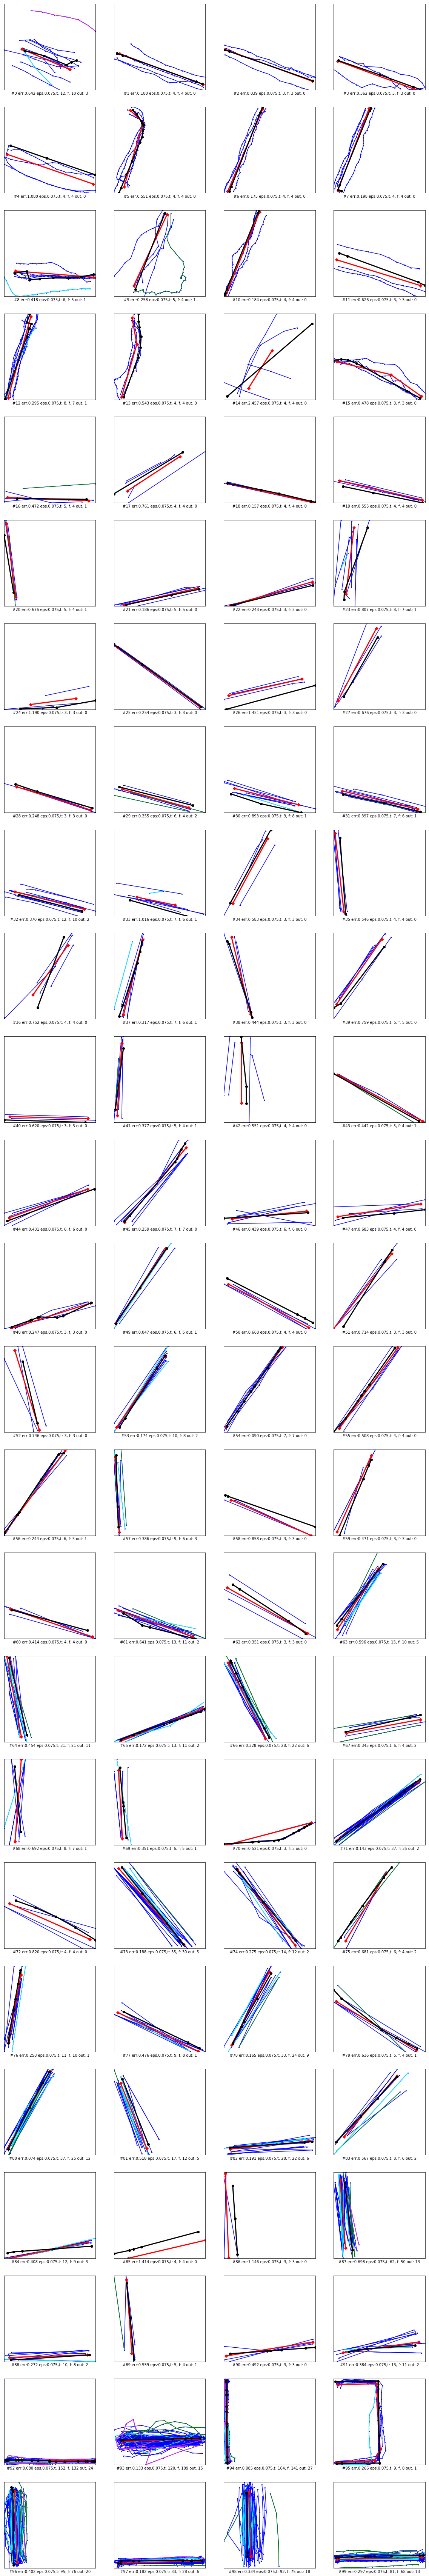

In [32]:

import matplotlib.pyplot as plt
errsum = 0.
def sho(i, ax, zmax,lenlim, eps):
    ss = SampleSet(i, ts[i])
    ss.getAvg(zmax, lenlim, eps)
    ss.pax(ax)
    return ss.err
    
    

ts = read_training("training_data")
r = 25

fig, axs = plt.subplots(nrows=r, ncols=4, figsize=(20,5*r))
li = sorted(list(ts.keys()))
faxs = [item for sublist in axs for item in sublist]

eps = .0755
zmax = 2.13
lenlim=(-1.23,1.8129)
errsum = 0.
for i, ax in enumerate(faxs):    
    errsum += sho(i, ax, zmax, lenlim, eps)
print(errsum)
plt.savefig("l6.png")

In [121]:
def median(lst):
    sortedLst = sorted(lst)
    lstLen = len(lst)
    index = (lstLen - 1) // 2    
    return sortedLst[index] 


class Traj:
    def __init__(self,xsys):
        xs, ys = xsys
        self.xs = np.array(xs)
        self.ys = np.array(ys)
        self.xd = np.diff(xs)
        self.yd = np.diff(ys)
        self.dists = np.linalg.norm([self.xd, self.yd],axis=0)
        self.cuts = np.cumsum(self.dists)
        self.d = np.hstack([0,self.cuts])
        
    def xyIncr(self):
        return self.xs[0]<self.xs[-1], self.ys[0]<self.ys[-1]
    
    def getPoints(self, offsets):        
        offdists = offsets * self.cuts[-1]
        #print("offdists:", offdists)
        #print("self.cuts:", self.cuts)
        ix = np.searchsorted(self.cuts, offdists)        
        #print("ix:", ix)
        offdists -= self.d[ix]
        #print("offdists decr:", offdists)
        #print("offidsts after decr:", offdists)
        segoffs = offdists/self.dists[ix]
        #print("xd:", self.xd)
        #print("yd:", self.yd)
        #print("xs:", self.xs)
        #print("ys:", self.ys)
        #print("seqoffs:", segoffs)
        x = self.xs[ix] + self.xd[ix]*segoffs
        y = self.ys[ix] + self.yd[ix]*segoffs
        return x,y        
       

    def getPoint(self, offset):     
        offdist = offset * self.cuts[-1]     
        i = np.searchsorted(self.cuts, offdist)
        #print("i:", i)
        #if i > 0:
        #print("decr: ", self.d[i])
        offdist -= self.d[i]
        #print("offidst after decr:", offdist)
        segoff = offdist/self.dists[i]
        xd = (self.xs[i+1] - self.xs[i])
        yd = (self.ys[i+1] - self.ys[i])
        #print("xd:", xd)
        #print("yd:", yd)
        #print("segoff:", segoff)
        x = self.xs[i] + xd*segoff
        y = self.ys[i] + yd*segoff
        return x,y

class SampleSet:
    def __init__(self, n, ll):
        # ll is list of tuples [x_array,y_array] for every trajectory in sample
        self.trajs = [Traj(l) for l in ll]
        self.n = n
        self.xp = None
        self.yp = None
        self.err= None
        
    def getDirectionDict(self):
        d = {}
        for i, t in enumerate(self.trajs):
            v = t.xyIncr()
            if v not in d:
                d[v] = [i]
            else:
                d[v].append(i)
        return d
    

        
        self.err = disterr(self.xp, self.yp, tx,ty)        
        
    def getAvg(self, lims, eps):
        self.endpoints()
        if len(self.trajs) > 3:
            ts, _, _ = self.getfilteredtrajs(lims)
        else:
            ts = self.trajs
        if len(ts) < 2:
            ts = self.trajs
        ########################################################################################
        #ts = self.trajs
        #print(self.n, "picked", len(ts), "from", len(self.trajs))
        
        trajLen = median([len(t.xs) for t in ts])
        offs = np.linspace(0,1,trajLen)
        xm = []
        ym = []
        for t in ts:
            xs, ys = t.getPoints(offs)            
            xm.append(xs)
            ym.append(ys)
        
        self.xp, self.yp = zip(*rdp(list(zip(np.mean(xm, axis=0),np.mean(ym, axis=0))), eps))
        tx = truth[self.n][0]
        ty = truth[self.n][1]
        
        self.err = disterr(self.xp, self.yp, tx,ty)
    
    
    def endpoints(self):
        
        cs = np.array([[self.trajs[0].xs[0],self.trajs[0].xs[-1]],
                       [self.trajs[0].ys[0],self.trajs[0].ys[-1]]])
        xs = np.hstack([t.xs[0] for t in self.trajs] + [t.xs[-1] for t in self.trajs])
        ys = np.hstack([t.ys[0] for t in self.trajs] + [t.ys[-1] for t in self.trajs])       
        #print("C1:", cs[0][0], cs[1][0])
        #print("C2:", cs[1][0], cs[1][1])
        clabs = []
        oldclabs = []
        for j in range(10):
            for i in range(len(xs)):
                ap = np.array([[xs[i]],[ys[i]]])
                dists = np.linalg.norm(ap - cs, axis=0)
                clabs.append(np.argmin(dists))
                #print(ap, "->", dists, np.argmin(dists))            
            cx = np.array([
                np.mean(xs[np.where(np.array(clabs)==0)]),
                np.mean(xs[np.where(np.array(clabs)==1)])])
            cy = np.array([
                np.mean(ys[np.where(np.array(clabs)==0)]),
                np.mean(ys[np.where(np.array(clabs)==1)])])
            if oldclabs == clabs:
                #print("early exit", j)
                break
            oldclabs = clabs
            clabs = []
        #if sum(clabs) == len(clabs)/2:
            #print("succ")        
        
        for i,l in enumerate(clabs[:len(clabs)//2]):
            if l == 1:
                #print("kmean reversing", i)
                oldT = self.trajs[i]                
                reversedTraj = (np.flip(oldT.xs, axis=0), np.flip(oldT.ys, axis=0))
                self.trajs[i] = Traj(reversedTraj)
                
             
                
    def zdist(self):
        xms = np.array([(t.xs[0]+t.xs[-1])/2 for t in self.trajs])
        yms = np.array([(t.ys[0]+t.ys[-1])/2 for t in self.trajs])
        xm = np.mean(xms)
        ym = np.mean(yms)
        #print(np.array([[xm],[ym]]) - np.array([xms,yms]))
        return zscore(np.linalg.norm(np.array([[xm],[ym]]) - np.array([xms,yms]), axis=0))
        
        
    def zlen(self):
        ls = np.array([t.cuts[-1] for t in self.trajs])
        #print(ls)
        return zscore(ls)
        
        # (a - a.mean(axis=0)) / a.std(axis=0)
    def getfilteredtrajs(self, lims):
        
        zl = self.zlen()
        #print(self.n, "zl", zl)
        #print("zl", zl)
        zd = self.zdist()
        #print("zd", zd)
        #print("zc", zc)
        lenlim, dislim= lims

        lenout = [self.trajs[i] for i in np.where((zl<lenlim[0])|(zl>lenlim[1]))[0]]
        disout = [self.trajs[i] for i in np.where((zd<dislim[0])|(zd>dislim[1]))[0]]
        
        lenix = (zl>lenlim[0])&(zl<lenlim[1])
        disix = (zd>dislim[0])&(zd<dislim[1])

        filtix = np.where(lenix&disix)[0]

        filtered = [self.trajs[i] for i in filtix]
        return filtered, lenout, disout
    
    
        
    def pax(self, ax, lims, eps):
        
        ax.set_xlim(0,1)
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_ylim(0,1)

        filtered, lenout, disout = self.getfilteredtrajs(lims)
        for _, t in enumerate(self.trajs):    
            ax.plot(t.xs,t.ys, c="b", marker="o", markersize=2)
        
        if len(self.trajs) > 3:    
            for n, t in enumerate(lenout):    
                ax.plot(t.xs,t.ys, c="cyan") 
            for n, t in enumerate(disout):    
                ax.plot(t.xs,t.ys, c="g")
        if self.xp is not None:
            ax.plot(self.xp,self.yp, marker='D', color='r', linewidth=3)
            
            #rx, ry = zip(*rdp(list(zip(self.xp,self.yp)), .05))
            #print(len(rx))
            #ax.plot(rx,ry, marker='D', color='red', linewidth=2)
        tx = truth[self.n][0]
        ty = truth[self.n][1]
        ax.plot(tx,ty, marker="o",color="black",linewidth=3)
            
        
        if self.xp is not None:
            ax.set_xlabel("%d err:%.3f eps:%.3f" % (self.n, self.err, eps))
        #for t in self.trajs:    
        #    ax.plot(t.xs,t.ys, linestyle='--', marker='o', color='grey')
        #if self.xp is not None:
        #    ax.plot(self.xp,self.yp, marker='D', color='r', linewidth=3)
        #ax.set_xlabel(str(self.n))
    def pax2(self, ax, lims, eps):
        
        ax.set_xlim(0,1)
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_ylim(0,1)

        filtered, lenout, disout = self.getfilteredtrajs(lims)
        for _, t in enumerate(self.trajs):    
            ax.plot(t.xs,t.ys, c="b", marker="o", markersize=2)
        
        if len(self.trajs) > 3:    
            for n, t in enumerate(lenout):    
                ax.plot(t.xs,t.ys, c="cyan") 
            for n, t in enumerate(disout):    
                ax.plot(t.xs,t.ys, c="g")
        if self.xp is not None:
            ax.plot(self.xp,self.yp, marker='D', color='r', linewidth=3)
                    
        
        
    def getAvg2(self):
        
        #oldT = self.trajs[0]                        
        #reversedTraj = (np.flip(oldT.xs,axis=0), np.flip(oldT.ys,axis=0))
        #self.trajs[0] = Traj(reversedTraj)
        
        trajLen = median([len(t.xs) for t in self.trajs])
        offs = np.linspace(0,1,trajLen)
        xm = []
        ym = []
        for t in self.trajs:
            print(t)
            xs, ys = t.getPoints(offs)            
            xm.append(xs)
            ym.append(ys)
        
        self.xp, self.yp = np.mean(xm, axis=0),np.mean(ym, axis=0)
        tx = truth[self.n][0]
        ty = truth[self.n][1]   
        
def disterr(x1,y1, x2, y2):        
    sd = np.array([x1[0]-x2[0],y1[0]-y2[0]])
    ed = np.array([x1[0]-x2[-1],y1[0]-y2[-1]])
    if np.linalg.norm(sd) > np.linalg.norm(ed):
        x2 = np.flip(x2, axis=0)
        y2 = np.flip(y2, axis=0)
        
    offs = np.linspace(0,1,10)
    xrs1, yrs1 = Traj((x1,y1)).getPoints(offs)
    xrs2, yrs2 = Traj((x2,y2)).getPoints(offs)
    return np.sum(np.linalg.norm([xrs1-xrs2, yrs1-yrs2],axis=0))
        
def zscore(l):
    if len(np.unique(l)) == 1:
        return np.full(len(l),0.)
    return (np.array(l)  - np.mean(l)) / np.std(l)
        
def sho(i,ax, lims, eps):
    ss = SampleSet(i, ts[i])
    ss.getAvg(lims, eps)
    ss.pax(ax, lims, eps)
    
def showPlain(i):
    f = plt.figure(figsize=(5,5))
    ax = f.gca()
    ss = SampleSet(i, ts[i])
    print(0, len(ss.trajs[0].xs))
    print(1, len(ss.trajs[1].xs))
    ixs = [0,2]
    ss.trajs = [ss.trajs[j] for j in ixs]
    ss.getAvg2()
    ss.pax2(ax, ((0,0),(0,0)),0)
    
    f.show()

def show(i, lims, eps):
    f = plt.figure(figsize=(5,5))
    ax = f.gca()
    ss = SampleSet(i, ts[i])
    ss.getAvg(lims, eps)
    ss.pax(ax,lims, eps)
    f.show()
# 16,33,42,46,69


In [190]:
def median(lst):
    sortedLst = sorted(lst)
    lstLen = len(lst)
    index = (lstLen - 1) // 2    
    return sortedLst[index] 


class Traj:
    def __init__(self,xsys):
        xs, ys = xsys
        self.xs = np.array(xs)
        self.ys = np.array(ys)
        self.xd = np.diff(xs)
        self.yd = np.diff(ys)
        self.dists = np.linalg.norm([self.xd, self.yd],axis=0)
        self.cuts = np.cumsum(self.dists)
        self.d = np.hstack([0,self.cuts])
        
    def xyIncr(self):
        return self.xs[0]<self.xs[-1], self.ys[0]<self.ys[-1]
    
    def getPoints(self, offsets):        
        offdists = offsets * self.cuts[-1]
        #print("offdists:", offdists)
        #print("self.cuts:", self.cuts)
        ix = np.searchsorted(self.cuts, offdists)        
        #print("ix:", ix)
        offdists -= self.d[ix]
        #print("offdists decr:", offdists)
        #print("offidsts after decr:", offdists)
        segoffs = offdists/self.dists[ix]
        #print("xd:", self.xd)
        #print("yd:", self.yd)
        #print("xs:", self.xs)
        #print("ys:", self.ys)
        #print("seqoffs:", segoffs)
        x = self.xs[ix] + self.xd[ix]*segoffs
        y = self.ys[ix] + self.yd[ix]*segoffs
        return x,y        
       

    def getPoint(self, offset):     
        offdist = offset * self.cuts[-1]     
        i = np.searchsorted(self.cuts, offdist)
        #print("i:", i)
        #if i > 0:
        #print("decr: ", self.d[i])
        offdist -= self.d[i]
        #print("offidst after decr:", offdist)
        segoff = offdist/self.dists[i]
        xd = (self.xs[i+1] - self.xs[i])
        yd = (self.ys[i+1] - self.ys[i])
        #print("xd:", xd)
        #print("yd:", yd)
        #print("segoff:", segoff)
        x = self.xs[i] + xd*segoff
        y = self.ys[i] + yd*segoff
        return x,y

class SampleSet:
    def __init__(self, n, ll):
        # ll is list of tuples [x_array,y_array] for every trajectory in sample
        self.trajs = [Traj(l) for l in ll]
        self.n = n
        self.xp = None
        self.yp = None
        self.err= None
        
    def getDirectionDict(self):
        d = {}
        for i, t in enumerate(self.trajs):
            v = t.xyIncr()
            if v not in d:
                d[v] = [i]
            else:
                d[v].append(i)
        return d
    

        
        self.err = disterr(self.xp, self.yp, tx,ty)        
        
    def getAvg(self, lims, eps):
        self.endpoints()
        if len(self.trajs) > 3:
            ts, _, _ = self.getfilteredtrajs(lims)
        else:
            ts = self.trajs
        if len(ts) < 2:
            ts = self.trajs
        ########################################################################################
        #ts = self.trajs
        #print(self.n, "picked", len(ts), "from", len(self.trajs))
        
        trajLen = median([len(t.xs) for t in ts])
        offs = np.linspace(0,1,trajLen)
        xm = []
        ym = []
        for t in ts:
            xs, ys = t.getPoints(offs)            
            xm.append(xs)
            ym.append(ys)
        
        self.xp, self.yp = zip(*rdp(list(zip(np.mean(xm, axis=0),np.mean(ym, axis=0))), eps))
        tx = truth[self.n][0]
        ty = truth[self.n][1]
        
        self.err = disterr(self.xp, self.yp, tx,ty)
    
    
    def endpoints(self):
        
        cs = np.array([[self.trajs[0].xs[0],self.trajs[0].xs[-1]],
                       [self.trajs[0].ys[0],self.trajs[0].ys[-1]]])
        xs = np.hstack([t.xs[0] for t in self.trajs] + [t.xs[-1] for t in self.trajs])
        ys = np.hstack([t.ys[0] for t in self.trajs] + [t.ys[-1] for t in self.trajs])       
        #print("C1:", cs[0][0], cs[1][0])
        #print("C2:", cs[1][0], cs[1][1])
        clabs = []
        oldclabs = []
        for j in range(10):
            for i in range(len(xs)):
                ap = np.array([[xs[i]],[ys[i]]])
                dists = np.linalg.norm(ap - cs, axis=0)
                clabs.append(np.argmin(dists))
                #print(ap, "->", dists, np.argmin(dists))            
            cx = np.array([
                np.mean(xs[np.where(np.array(clabs)==0)]),
                np.mean(xs[np.where(np.array(clabs)==1)])])
            cy = np.array([
                np.mean(ys[np.where(np.array(clabs)==0)]),
                np.mean(ys[np.where(np.array(clabs)==1)])])
            if oldclabs == clabs:
                #print("early exit", j)
                break
            oldclabs = clabs
            clabs = []
        #if sum(clabs) == len(clabs)/2:
            #print("succ")        
        
        for i,l in enumerate(clabs[:len(clabs)//2]):
            if l == 1:
                #print("kmean reversing", i)
                oldT = self.trajs[i]                
                reversedTraj = (np.flip(oldT.xs, axis=0), np.flip(oldT.ys, axis=0))
                self.trajs[i] = Traj(reversedTraj)
                
             
                
    def zdist(self):
        xms = np.array([(t.xs[0]+t.xs[-1])/2 for t in self.trajs])
        yms = np.array([(t.ys[0]+t.ys[-1])/2 for t in self.trajs])
        xm = np.mean(xms)
        ym = np.mean(yms)
        #print(np.array([[xm],[ym]]) - np.array([xms,yms]))
        return zscore(np.linalg.norm(np.array([[xm],[ym]]) - np.array([xms,yms]), axis=0))
        
        
    def zlen(self):
        ls = np.array([t.cuts[-1] for t in self.trajs])
        #print(ls)
        return zscore(ls)
        
        # (a - a.mean(axis=0)) / a.std(axis=0)
    def getfilteredtrajs(self, lims):
        
        zl = self.zlen()
        #print(self.n, "zl", zl)
        #print("zl", zl)
        zd = self.zdist()
        #print("zd", zd)
        #print("zc", zc)
        lenlim, dislim= lims

        lenout = [self.trajs[i] for i in np.where((zl<lenlim[0])|(zl>lenlim[1]))[0]]
        disout = [self.trajs[i] for i in np.where((zd<dislim[0])|(zd>dislim[1]))[0]]
        
        lenix = (zl>lenlim[0])&(zl<lenlim[1])
        disix = (zd>dislim[0])&(zd<dislim[1])

        filtix = np.where(lenix&disix)[0]

        filtered = [self.trajs[i] for i in filtix]
        return filtered, lenout, disout
    
    
        
    def pax(self, ax, lims, eps):
        
        ax.set_xlim(0,1)
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_ylim(0,1)

        filtered, lenout, disout = self.getfilteredtrajs(lims)
        for _, t in enumerate(self.trajs):    
            ax.plot(t.xs,t.ys, c="b", marker="o", markersize=2)
        
        if len(self.trajs) > 3:    
            for n, t in enumerate(lenout):    
                ax.plot(t.xs,t.ys, c="cyan") 
            for n, t in enumerate(disout):    
                ax.plot(t.xs,t.ys, c="g")
        if self.xp is not None:
            ax.plot(self.xp,self.yp, marker='D', color='r', linewidth=3)
            
            #rx, ry = zip(*rdp(list(zip(self.xp,self.yp)), .05))
            #print(len(rx))
            #ax.plot(rx,ry, marker='D', color='red', linewidth=2)
        tx = truth[self.n][0]
        ty = truth[self.n][1]
        ax.plot(tx,ty, marker="o",color="black",linewidth=3)
            
        
        if self.xp is not None:
            ax.set_xlabel("%d err:%.3f eps:%.3f" % (self.n, self.err, eps))
        #for t in self.trajs:    
        #    ax.plot(t.xs,t.ys, linestyle='--', marker='o', color='grey')
        #if self.xp is not None:
        #    ax.plot(self.xp,self.yp, marker='D', color='r', linewidth=3)
        #ax.set_xlabel(str(self.n))
    def pax2(self, ax, lims, eps):
        
        ax.set_xlim(0,1)
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_ylim(0,1)

        filtered, lenout, disout = self.getfilteredtrajs(lims)
        for _, t in enumerate(self.trajs):    
            ax.plot(t.xs,t.ys, c="b", marker="o", markersize=2)
        
        if len(self.trajs) > 3:    
            for n, t in enumerate(lenout):    
                ax.plot(t.xs,t.ys, c="cyan") 
            for n, t in enumerate(disout):    
                ax.plot(t.xs,t.ys, c="g")
        if self.xp is not None:
            ax.plot(self.xp,self.yp, marker='D', color='r', linewidth=3)
                    
        
        
    def getAvg2(self):
        
        #oldT = self.trajs[0]                        
        #reversedTraj = (np.flip(oldT.xs,axis=0), np.flip(oldT.ys,axis=0))
        #self.trajs[0] = Traj(reversedTraj)
        
        trajLen = median([len(t.xs) for t in self.trajs])
        offs = np.linspace(0,1,trajLen)
        xm = []
        ym = []
        for t in self.trajs:
            print(t)
            xs, ys = t.getPoints(offs)            
            xm.append(xs)
            ym.append(ys)
        
        self.xp, self.yp = np.mean(xm, axis=0),np.mean(ym, axis=0)
        tx = truth[self.n][0]
        ty = truth[self.n][1]   
        
def disterr(x1,y1, x2, y2):        
    sd = np.array([x1[0]-x2[0],y1[0]-y2[0]])
    ed = np.array([x1[0]-x2[-1],y1[0]-y2[-1]])
    if np.linalg.norm(sd) > np.linalg.norm(ed):
        x2 = np.flip(x2, axis=0)
        y2 = np.flip(y2, axis=0)
        
    offs = np.linspace(0,1,10)
    xrs1, yrs1 = Traj((x1,y1)).getPoints(offs)
    xrs2, yrs2 = Traj((x2,y2)).getPoints(offs)
    return np.sum(np.linalg.norm([xrs1-xrs2, yrs1-yrs2],axis=0))
        
def zscore(l):
    if len(np.unique(l)) == 1:
        return np.full(len(l),0.)
    return (np.array(l)  - np.mean(l)) / np.std(l)
        
def sho(i,ax, lims, eps):
    ss = SampleSet(i, ts[i])
    ss.getAvg(lims, eps)
    ss.pax(ax, lims, eps)
    
def showPlain(i):
    f = plt.figure(figsize=(5,5))
    ax = f.gca()
    ss = SampleSet(i, ts[i])
    print(0, len(ss.trajs[0].xs))
    print(1, len(ss.trajs[1].xs))
    ixs = [0,2]
    ss.trajs = [ss.trajs[j] for j in ixs]
    ss.getAvg(((0,0),(0,0)),0)
    ss.pax(ax, ((0,0),(0,0)),0)
    
    f.show()

def show(i, lims, eps):
    f = plt.figure(figsize=(5,5))
    ax = f.gca()
    ss = SampleSet(i, ts[i])
    #ss.getAvg(lims, eps)
    ss.pax(ax,lims, eps)
    f.show()
# 16,33,42,46,69


1. segment:
 x: [0.   0.44 0.55]
 y: [0.46 0.35 0.2 ]
2. segment:
 x: [0.18 0.29 0.38 0.46 0.53 0.62 0.72]
 y: [0.32 0.28 0.24 0.2  0.16 0.14 0.09]
3. segment:
 x: [0.23 0.33 0.39 0.52]
 y: [0.43 0.27 0.2  0.06]
4. segment:
 x: [0.77 0.62 0.49 0.35 0.2 ]
 y: [0.25 0.3  0.36 0.43 0.49]
5. segment:
 x: [0.77 0.59 0.43 0.28]
 y: [0.43 0.46 0.51 0.58]
6. segment:
 x: [0.81 0.68 0.55 0.42 0.33]
 y: [0.28 0.36 0.42 0.49 0.59]
7. segment:
 x: [0.21 0.33 0.45 0.57 0.69 0.81]
 y: [0.41 0.36 0.31 0.27 0.26 0.28]
8. segment:
 x: [1.   0.91 0.81 0.69 0.55 0.42 0.29]
 y: [0.68 0.75 0.81 0.85 0.87 0.9  0.92]
9. segment:
 x: [0.84 0.72 0.59 0.45 0.23]
 y: [0.32 0.36 0.4  0.45 0.57]
10. segment:
 x: [0.17 0.27 0.39 0.5  0.58 0.62]
 y: [0.57 0.58 0.52 0.47 0.37 0.25]
11. segment:
 x: [0.09 0.18 0.25 0.32 0.4  0.5  0.6 ]
 y: [0.28 0.24 0.2  0.16 0.11 0.06 0.  ]
12. segment:
 x: [0.7  0.59 0.47 0.35 0.23]
 y: [0.24 0.31 0.35 0.41 0.46]


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


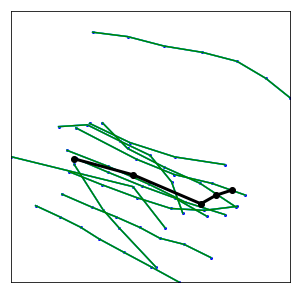

In [192]:
import numpy as np
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
for n, xy in enumerate(ts[0]):
    print("%d. segment:" % (n+1))
    print(" x:", xy[0])
    print(" y:", xy[1])

show(0,((0,0),(0,0)),0.1)

0 16
1 14


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


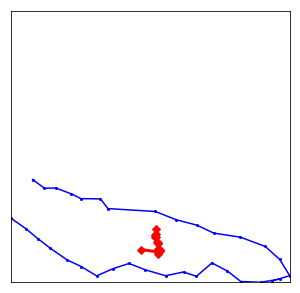

In [122]:

showPlain(3)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


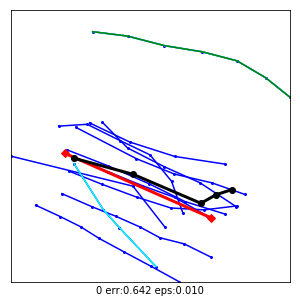

In [87]:
%matplotlib inline

for i in range(1):
    show(i, goodlims, .01)

TypeError: flip() missing 1 required positional argument: 'axis'

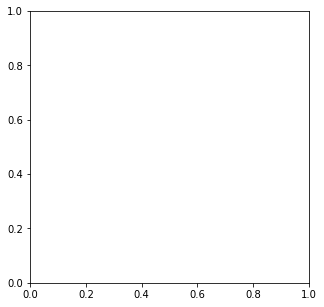

In [71]:
hardlims = ((-1,1),(-1,1))
show(98, goodlims, .8)

In [70]:
# backup 51
lenlim = (-1.3,1.95)
dislim = (-8.,1.9)


goodlims = (lenlim,dislim)

In [14]:


errs = []
lens = []
for i in ts:
    ss = SampleSet(i, ts[i])
    ss.getAvg(goodlims, .01)
    errs.append(ss.err)
    lens.append(len(ss.trajs))

l20 = [l for l in lens if l<20]
e20 = [errs[i] for i,l in enumerate(lens) if l < 20]
plt.scatter(e20,l20)
plt.figure()

plt.hist(l20, bins=30)
plt.figure()
plt.hist(lens, bins=30)
print(sum(errs))

cs [3.10739713 3.04441116 3.09494132 3.12533563 3.09693888 3.08799621
 3.1345391  3.01044204 2.6842894 ]
zc [ 0.48867719  0.01129269  0.39427183  0.62463702  0.40941182  0.34163335
  0.69439212 -0.24616674 -2.71814928]
cs [0.        0.        0.        0.0621398]
zc [-0.57735027 -0.57735027 -0.57735027  1.73205081]
cs [0.08583374 0.06875899 0.0999274  0.         0.         0.00096597]
zc [ 1.00098133  0.60582691  1.32714555 -0.98543633 -0.98543633 -0.96308114]
cs [0.06264179 0.01248734 0.09112388 0.29874153 0.05149033 0.01006458
 0.02852051]
zc [-0.17813783 -0.71461244  0.12651942  2.3472914  -0.29741884 -0.74052732
 -0.54311439]
cs [3.13013597e+00 3.82555982e-01 2.50116324e-02 1.70916505e-02
 2.93015434e+00 3.10523770e+00 3.12409808e+00 2.98730179e+00
 2.26120579e+00 3.11700051e+00 3.11442443e+00 1.40320467e-02
 3.05330204e+00 1.64212379e-01 3.12168712e+00 1.52025400e-02
 6.14925348e-02 3.08342750e+00 3.07718405e+00 4.10783967e-03
 4.89011000e-02 2.39953150e-01 1.18925844e-02 2.972876

zc [ 1.6460561  -0.7922353  -0.04067371 -0.81314708]
cs [0.22858794 0.6325211  0.49807642 1.1873012 ]
zc [-1.16706046 -0.01172847 -0.39626792  1.57505684]
cs [3.08219644 3.11689    3.08513386 3.06348668 3.07878475 3.1206527
 3.13510812 3.12642082 3.09321336 3.10406802 2.97731412 3.13987206
 3.13062683 3.14098174 3.13079612 3.10492841 3.01590524 2.80122457
 3.13191546 0.14851228 3.13121184 0.04787361 3.12979233 3.12242663
 3.10004355 3.11074444 3.09830189 3.14115047 3.11769599 3.13838189
 2.39215855 3.06623215 3.11062297 1.90233493 3.10539514 3.11223596
 2.97405181 3.12188305 3.08219644 2.70147073 3.134868   3.12531953
 3.12640449 2.02681836 3.11891567 3.07661413 3.07975247 2.86089644
 3.12517837 3.11689    3.07132349 3.09490644 3.09996194 2.90547968
 3.09706775 3.08650864 3.10034736 3.12940088 3.07589303 3.11825103
 3.07726808 3.10896448 3.07511901 3.13080181 3.12358862 3.13021028
 3.13895439 2.81074385 3.13445311 3.12591755 3.1324712  3.12127579
 3.0497064  3.12171488 2.96839768 3.110

zc [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
cs [0.18609361 0.11672906 0.01074635 0.09157984 0.         0.06906735
 0.02056298]
zc [ 1.85899251  0.74169582 -0.96543165  0.33660214 -1.1385296  -0.02602
 -0.80730923]
cs [0. 0. 0. 0. 0. 0.]
zc [0. 0. 0. 0. 0. 0.]
cs [0.56801615 0.         0.         0.         0.01470259]
zc [ 1.99936398 -0.51611875 -0.51611875 -0.51611875 -0.45100775]
cs [0.48829142 3.05990967 0.35596629 2.9589728  1.07193565 0.35024696
 3.01263538 2.97140911]
zc [-1.04858888  1.03309476 -1.15570394  0.95138799 -0.57613825 -1.16033365
  0.99482699  0.96145498]
cs [0.96218208 0.36871226 2.75651953 0.28434243]
zc [-0.13136712 -0.72760618  1.671343   -0.81236969]
cs [0.07761821 0.         0.         0.         0.         0.
 0.         0.10297767 0.         0.         0.         0.01010095
 0.         0.         0.         0.         0.         0.
 0.         0.22190829 0.18875075 0.07761821 0.         0.07550202
 0.         0.         0.         0.        ]
zc [ 0.879

In [15]:
errs = []
for i in ts:
    ss = SampleSet(i, ts[i])
    ss.getAvg(nolims, .01)
    errs.append(ss.err)
plt.hist(errs, bins=50)
print(sum(errs))
    

NameError: name 'nolims' is not defined

In [17]:
r =2 

fig, axs = plt.subplots(nrows=r, ncols=4, figsize=(20,5*r))
li = sorted(list(ts.keys()))
faxs = [item for sublist in axs for item in sublist]

for i, ax in enumerate(faxs):
    sho(i, ax, nolims, .01)
plt.savefig("l3.png")

NameError: name 'nolims' is not defined

==== 9
early exit 1
succ
kmean reversing 1
kmean reversing 3
kmean reversing 4
picked 5 from 5
zl [ 1.99316391 -0.35398802 -0.57464646 -0.5830589  -0.48147054]
3
==== 13
early exit 1
succ
picked 4 from 4
zl [ 0.13127388 -1.22647074 -0.42163029  1.51682715]
3
==== 15
early exit 1
succ
kmean reversing 2
picked 3 from 3
zl [-1.2312805  1.2181029  0.0131776]
4


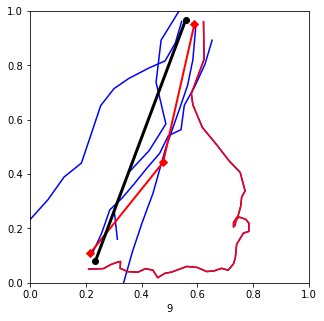

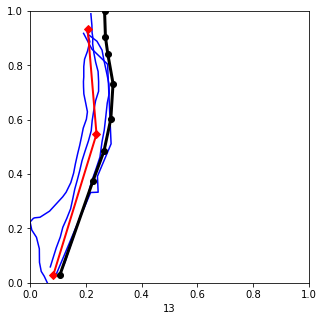

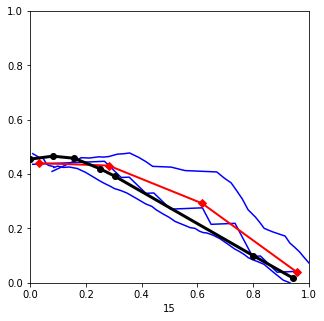

In [130]:

#for i in sorted(list(ts.keys()))[:1]:
for i in [9,13,15]:
    print("====",i)
    ss = SampleSet(i, ts[i])
    ss.getAvg()
    ss.plot()

/home/tomk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in true_divide


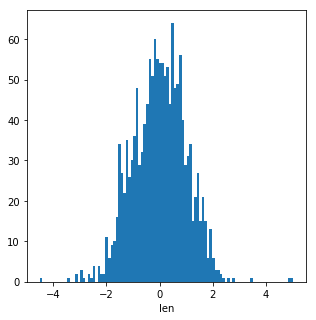

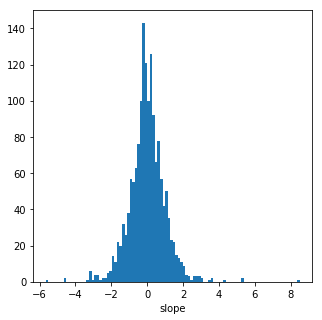

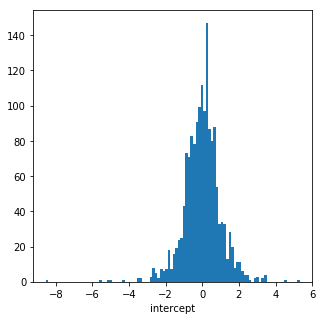

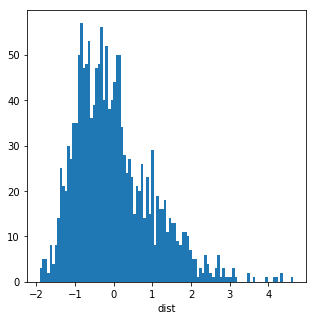

In [44]:
%precision 3
import matplotlib.pyplot as plt
n = 93
ss = SampleSet(n,ts[n])
zl,zs,zi,zd = [], [],[],[]
zs,zi = ss.zslopeintr()
zd = ss.zdist()

for i in ts:
    ss = SampleSet(i,ts[i])
    if len(ss.trajs) > 3:
        zl = np.hstack([zl,ss.zlen()])
        zd = np.hstack([zd,ss.zdist()])
        _zs, _zi = ss.zslopeintr()
        zs = np.hstack([zs, _zs])
        zi = np.hstack([zi, _zi])

def figu(d, lab):
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    ax.set_xlabel(lab)
   
    _ = ax.hist(d, bins=100)
figu(zl,"len")
figu(zs,"slope")
figu(zi,"intercept")
figu(zd,"dist")

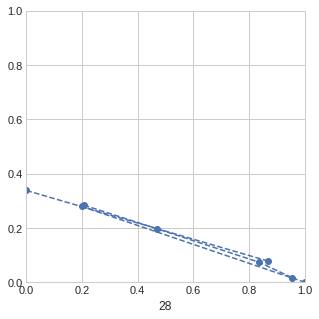

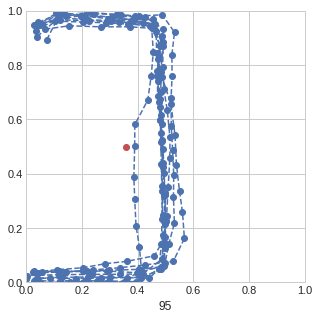

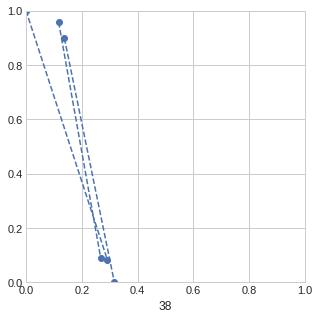

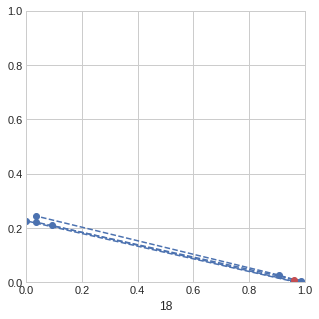

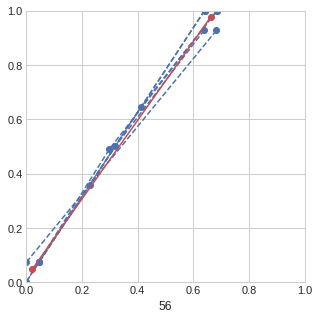

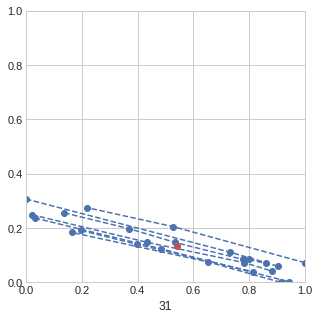

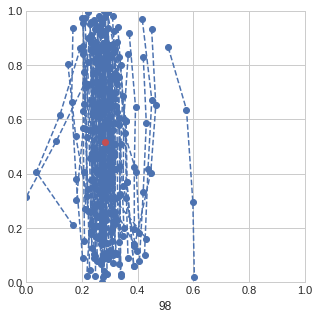

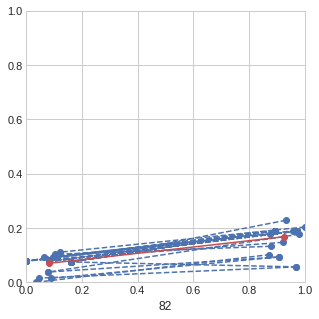

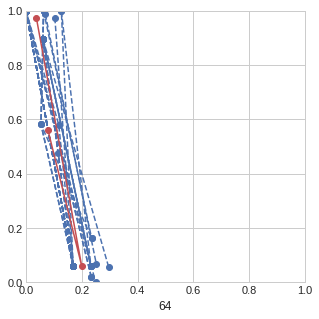

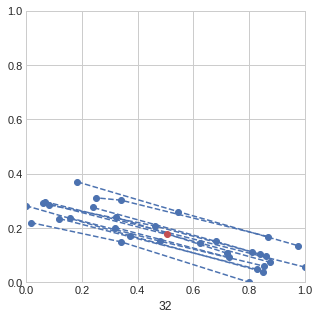

In [97]:
from sklearn.cluster import DBSCAN



class Traj:
    def __init__(self):
        self.xs = xs
        self.ys = ys
        self.dists = np.linalg.norm([xs[:-1]-xs[1:], ys[:-1]-ys[1:]],axis=0)
        self.totaldist = sum(self.dists)
    def getpoint(offset):
        offdist = offset * self.totaldist
        ix = np.argmax(self.dists < offdist)
        

            

def getavg(df, eps):    
    X = df[["x","y"]].values
    

    clustering = DBSCAN(eps=eps, min_samples=5).fit(X)
    df["l"] = clustering.labels_

    xf = []
    yf = []
    for l in sorted(df.l.unique()):
        if l < 0:
            continue
        xl = df[df.l == l].x
        xf.append(sum(xl)/len(xl))
        yl = df[df.l == l].y
        yf.append(sum(yl)/len(yl))
    return xf, yf

def plotdf(df, la, eps=.2):
        
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    for n in df.n.unique():    
        x = df[df.n==n].x.values
        y = df[df.n==n].y.values    
        ax.plot(x,y, linestyle='--', marker='o', color='b')
    xf, yf = getavg(df, eps)
    ax.plot(xf,yf, marker='o', color='r')
    ax.set_xlabel(la)
    


for k in list(ts.keys())[:10]:    
    plotdf(ts[k],k,.3)

In [43]:
df.loc[[1,2,8]]

,x,y,n
1,0.083431,0.055145,0
2,0.433953,0.866108,1
8,0.433953,0.866108,4


In [10]:
clustering

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=1, n_jobs=None, p=None)

In [11]:
df[["x","y"]].values

array([[1.       , 0.2089335],
       [0.158354 , 0.       ],
       [1.       , 0.2089335],
       [0.158354 , 0.       ],
       [1.       , 0.2089335],
       [0.158354 , 0.       ],
       [1.       , 0.2089335],
       [0.158354 , 0.       ]])

In [29]:

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

In [13]:
 fmri = sns.load_dataset("fmri")

In [14]:
fmri.query("region == 'frontal'")

,subject,timepoint,event,region,signal
67,s0,0,stim,frontal,-0.021452
170,s2,6,stim,frontal,0.101050
267,s10,4,stim,frontal,0.030044
268,s11,4,stim,frontal,0.075957
269,s3,0,stim,frontal,0.011056
270,s4,0,stim,frontal,-0.017516
271,s5,0,stim,frontal,-0.022977
272,s6,0,stim,frontal,-0.007947
273,s7,0,stim,frontal,-0.020864
274,s8,0,stim,frontal,0.018852
